# Compare AEMO wind and sola observations with modelled

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:00:00"
cores = 12
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.17:35605,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [99]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [6]:
# %cd /g/data/w42/dr6273/work/seasonal_energy/

# import functions as fn

In [7]:
year = "2023"

## Load modelled data

In [8]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [9]:
path_power = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

#### Wind and solar power

For REZs
- Current/planned generation capacities. These sometimes underestimate observed power (i.e. from installed farms) because it spreads the capacity around the REZ, rather than being loaded on a single grid cell.

In [10]:
def preprocess(ds):
    """
    Select 2023 only
    """
    return ds.sel(time="2023")

In [14]:
wind_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess
)

In [16]:
solar_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess
)

We also use the power from farms outside the REZs, and add this to the REZ power

In [18]:
wind_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess
).astype("float32")

In [19]:
solar_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    preprocess=preprocess
).astype("float32")

Add these together

In [20]:
def get_REZ_for_state(ds, state):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds.REZ.values if i[0] == state[0]]

In [21]:
def sum_REZ_power_for_states(ds, states=["NSW", "QLD", "VIC", "SA", "TAS"]):
    """
    Return array of ds summed for each REZ in each state
    
    ds: dataset with REZ dimension
    states: list, of strings of states
    """
    da_list = []
    for state in states:
        r = get_REZ_for_state(ds, state)
        da = ds.sel(REZ=r).sum("REZ").expand_dims({"region": [state]})
        da_list.append(da)
    return xr.concat(da_list, dim="region")

In [22]:
wind_rez_current = sum_REZ_power_for_states(wind_rez_current) + wind_outside_rez

In [23]:
solar_rez_current = sum_REZ_power_for_states(solar_rez_current) + solar_outside_rez

Hack add TAS for solar to keep it same format as site power.

In [25]:
solar_tas = xr.DataArray(
    np.zeros(len(solar_rez_current.time)),
    dims=["time"],
    coords={"time": solar_rez_current.time}
).expand_dims({"region": ["TAS"]})

In [26]:
solar_rez_current = xr.concat([solar_rez_current.power, solar_tas], "region").to_dataset(name="power")

In [101]:
wind_rez_current = wind_rez_current.compute()

In [102]:
solar_rez_current = solar_rez_current.compute()

## Load AEMO data

In [40]:
def open_aemo_obs(fuel_type, year):
    """
    Open monthly data and concatenate
    
    fuel_type: str, "wind" or "solar"
    year: str, year to open.
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    df_list = []
    for month in months:
        df = pd.read_csv(
            "/scratch/w42/dr6273/processed_AEMO/aemo_hourly_" + fuel_type + "_" + year + "_" + month + ".csv",
            index_col=[0,1]
        )
        df_list.append(df)
        
    return pd.concat(df_list, axis=0)

In [81]:
def df_to_xarray(df):
    """
    Convert AEMO obs dataframe to xarray
    """
    # Convert to xarray DataSet
    ds = df.to_xarray()
    # Rename dimensions and variable name
    ds = ds.rename({"Region": "region", "SETTLEMENTDATE": "time", "INITIALMW": "power"})
    # Ensure coordinates are correct data type
    ds = ds.assign_coords({
        "region": ["NSW", "QLD", "SA", "TAS", "VIC"],
        "time": pd.to_datetime(ds["time"])
    })
    # Re-order region coordinate to match modelled data
    ds = ds.reindex({"region": ["NSW", "QLD", "VIC", "SA", "TAS"]})
    
    return ds

In [107]:
aemo_wind = open_aemo_obs("wind", year)

In [108]:
aemo_solar = open_aemo_obs("solar", year)
# Pad with NaNs for TAS
aemo_solar = aemo_solar.reindex_like(aemo_wind)

In [109]:
aemo_wind = df_to_xarray(aemo_wind).compute()

In [110]:
aemo_solar = df_to_xarray(aemo_solar).compute()

## Compare

In [135]:
def plot_comparison(region, fuel_type, obs, mod, energy_units):
    """
    Plot scatter and histograms comparing obs and mod
    """
    fig, ax = plt.subplots(1, 2, figsize=(7,3))

    ax[0].scatter(obs, mod, c=range(len(obs)), alpha=0.5)

    line_coords = np.arange(obs.min().min(), obs.max().max())
    ax[0].plot(line_coords, line_coords, color="r")

    ax[0].set_xlabel("Observed [" + energy_units + "]")
    ax[0].set_ylabel("Modelled [" + energy_units + "]")
    ax[0].set_title(region + ", " + fuel_type, loc="left", fontsize=10)

    _ = ax[1].hist(obs, alpha=0.5, label="Obs")
    _ = ax[1].hist(mod, alpha=0.5, label="Model")
    ax[1].legend()
    ax[1].set_ylabel("Count [-]")
    ax[1].set_xlabel("Energy [" + energy_units + "]")
    ax[1].set_title(region + ", " + fuel_type, loc="left", fontsize=10)

    plt.tight_layout()

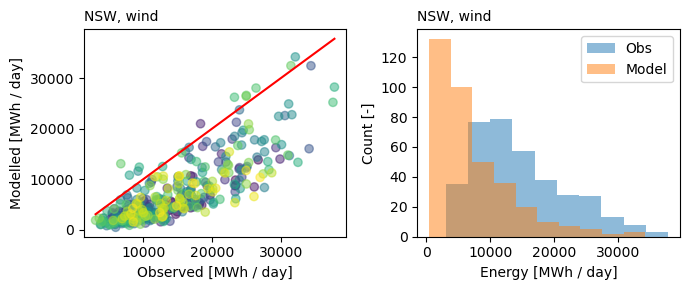

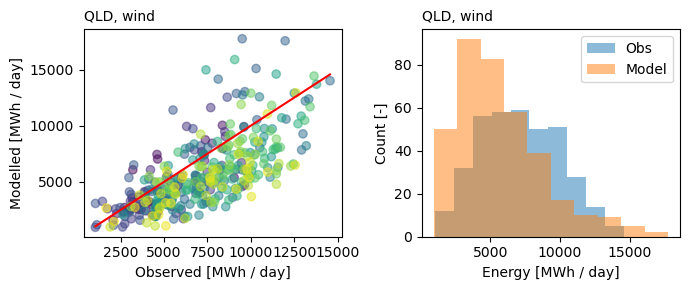

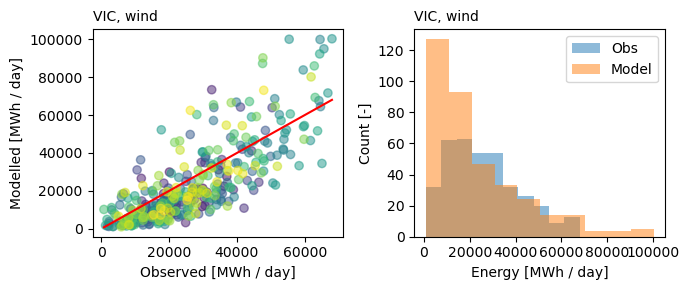

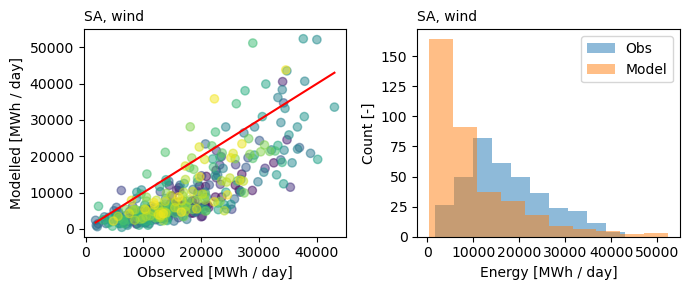

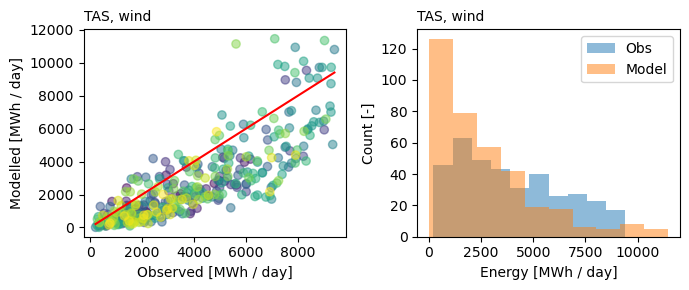

In [136]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1D").sum(),
        wind_rez_current.sel(region=region)["power"].resample(time="1D").sum(),
        "MWh / day"
    )

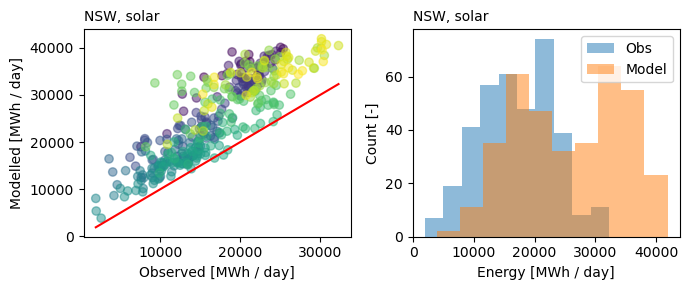

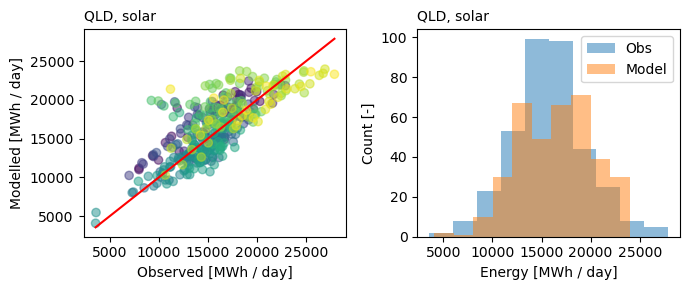

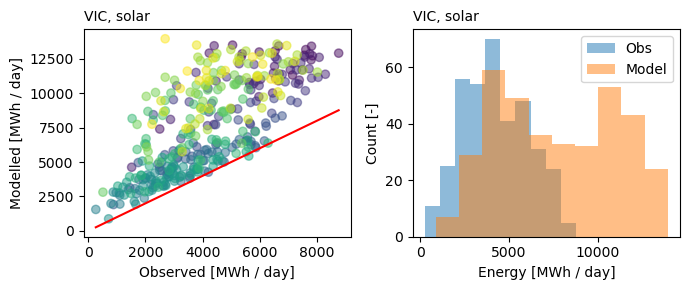

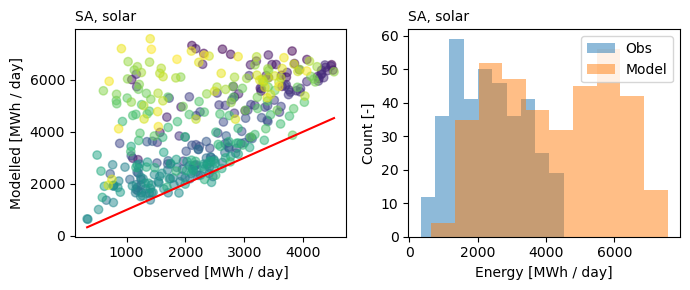

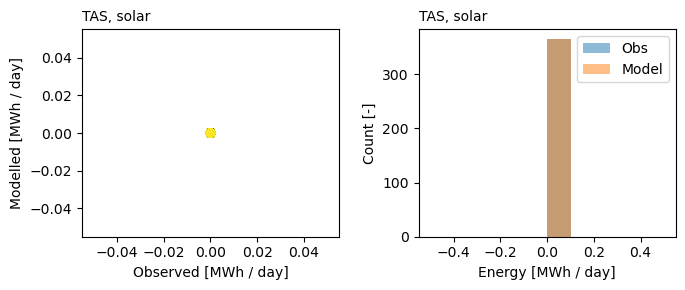

In [139]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "solar",
        aemo_solar.sel(region=region)["power"].resample(time="1D").sum(),
        solar_rez_current.sel(region=region)["power"].resample(time="1D").sum(),
        "MWh / day"
    )

### Find scaling factors for bias correction

In [147]:
# openNEM_solar_2023 = np.array([6368, 5845, 1546, 825, 0]) * 1000
# openNEM_wind_2023 = np.array([5754, 2605, 11076, 6304, 1890]) * 1000

In [170]:
wind_rez_scaled = wind_rez_current.assign_coords(
    # scale_factor_2023=("region", wind_rez_current.power.sum("time").values / openNEM_wind_2023)
    scale_factor_2023=(
        "region",
        aemo_wind.power.sum("time").values / wind_rez_current.power.sum("time").values
    )
)

In [171]:
solar_rez_scaled = solar_rez_current.assign_coords(
    # scale_factor_2023=("region", solar_rez_current.power.sum("time").values / openNEM_solar_2023)
    scale_factor_2023=(
        "region",
        aemo_solar.power.sum("time").values / solar_rez_current.power.sum("time").values
    )
)

/jobfs/130388641.gadi-pbs/ipykernel_1741832/1687749067.py:5: RuntimeWarning: invalid value encountered in divide
  aemo_solar.power.sum("time").values / solar_rez_current.power.sum("time").values


In [172]:
wind_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([2.02321105, 1.25639303, 1.13581679, 1.72883961, 1.47794378])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 2.023 1.256 1.136 1.729 1.478

In [173]:
solar_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([0.6638736 , 0.95382913, 0.54762614, 0.55381373,        nan])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 0.6639 0.9538 0.5476 0.5538 nan

In [174]:
wind_rez_scaled = wind_rez_scaled.power * wind_rez_scaled.scale_factor_2023
solar_rez_scaled = solar_rez_scaled.power * solar_rez_scaled.scale_factor_2023

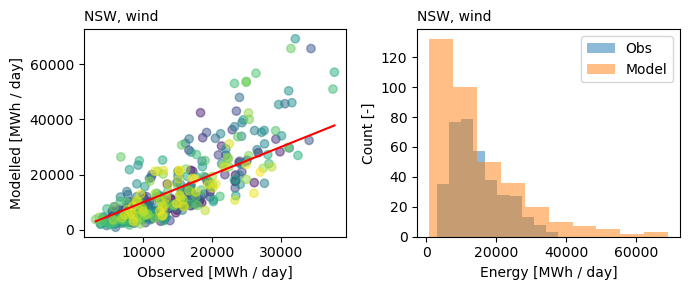

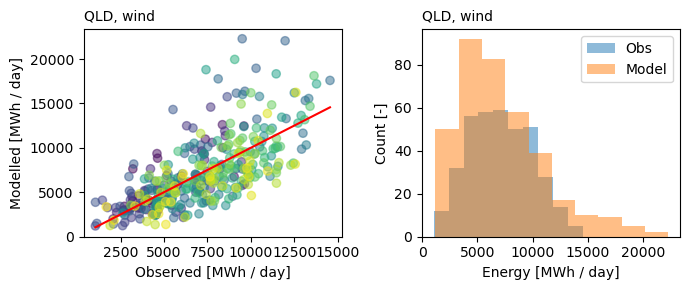

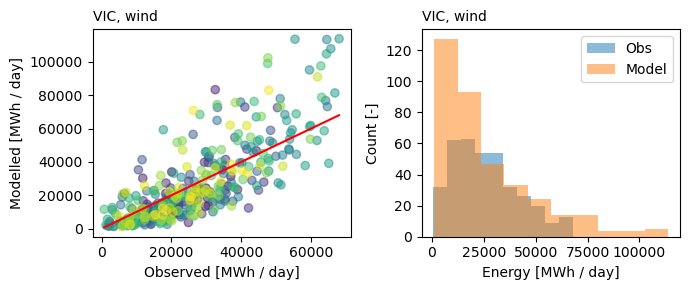

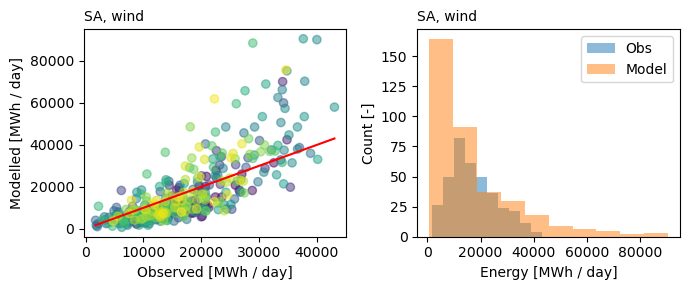

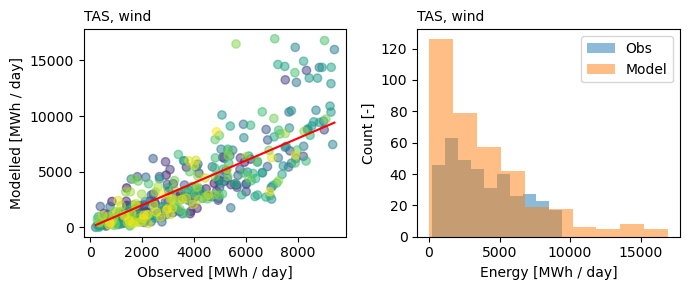

In [166]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1D").sum(),
        wind_rez_scaled.sel(region=region).resample(time="1D").sum(),
        "MWh / day"
    )

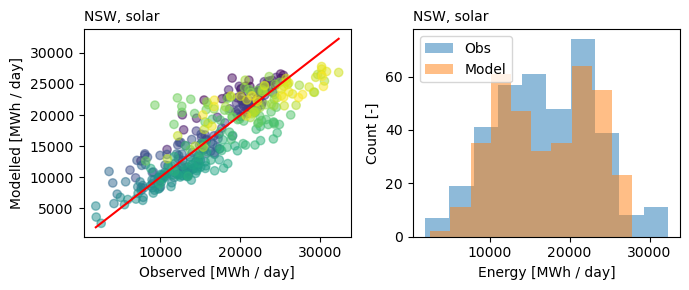

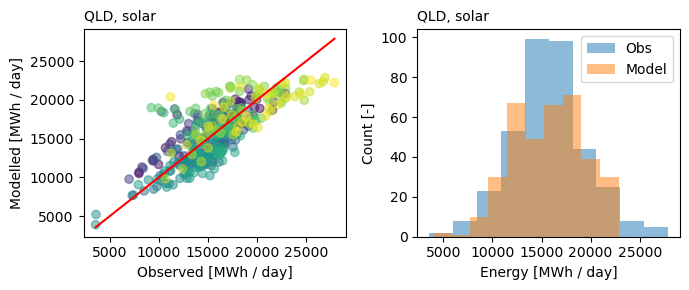

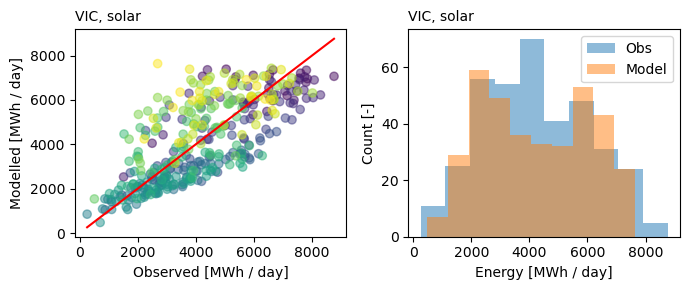

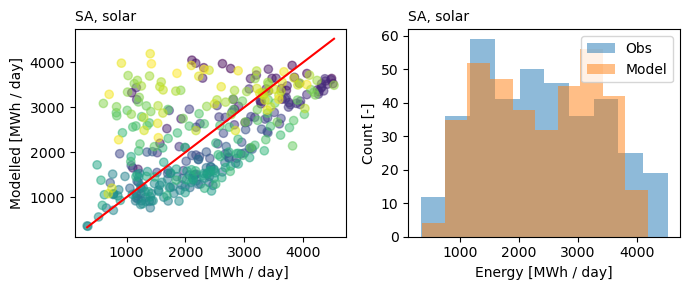

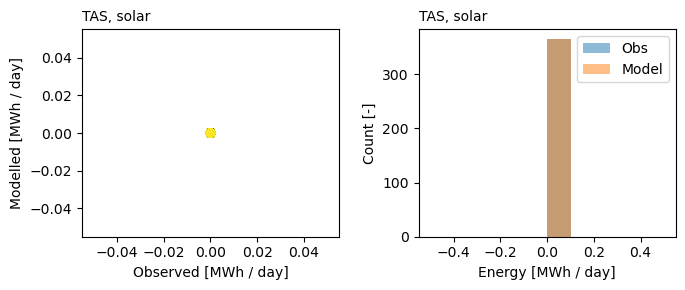

In [167]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "solar",
        aemo_solar.sel(region=region)["power"].resample(time="1D").sum(),
        solar_rez_scaled.sel(region=region).resample(time="1D").sum(),
        "MWh / day"
    )

## Monthly

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/group

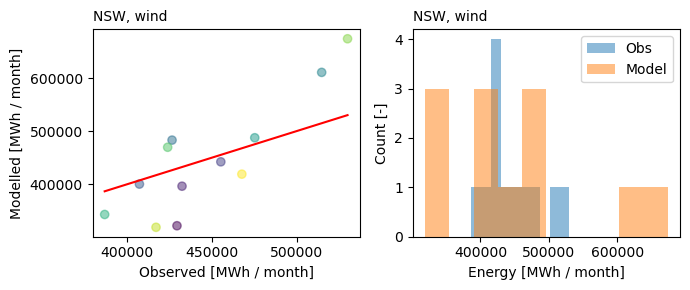

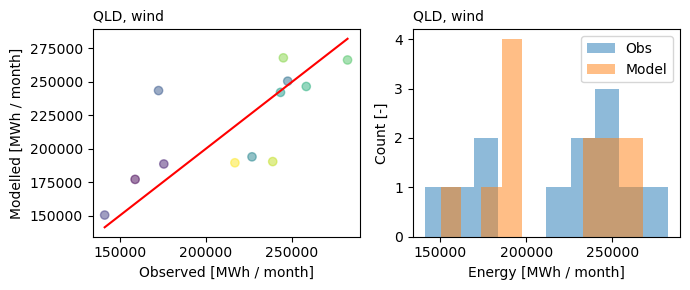

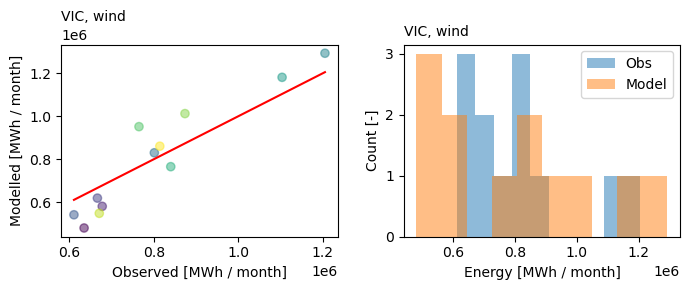

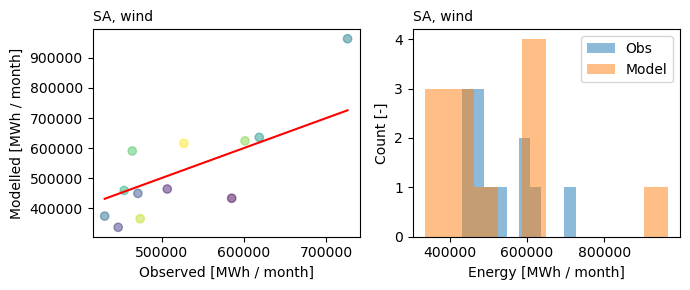

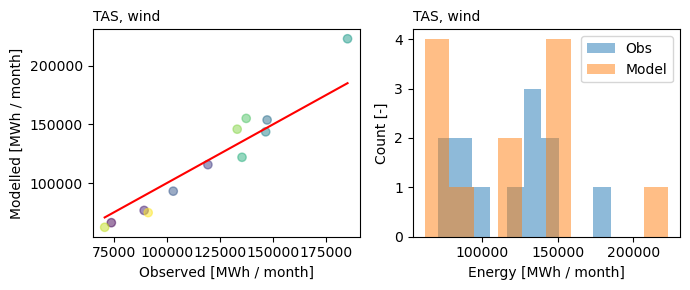

In [168]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1M").sum(),
        wind_rez_scaled.sel(region=region).resample(time="1M").sum(),
        "MWh / month"
    )

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/group

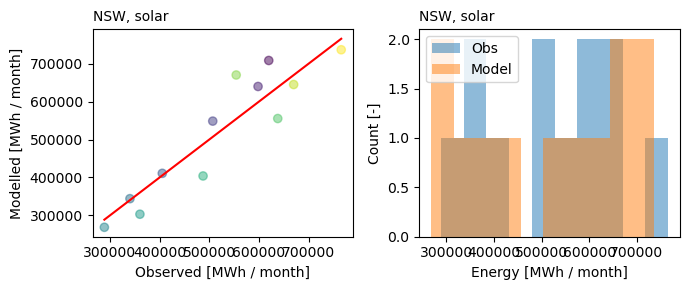

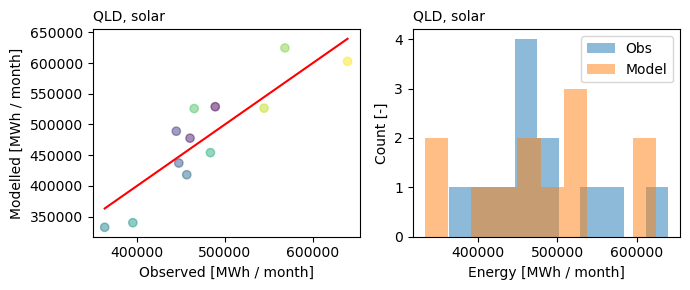

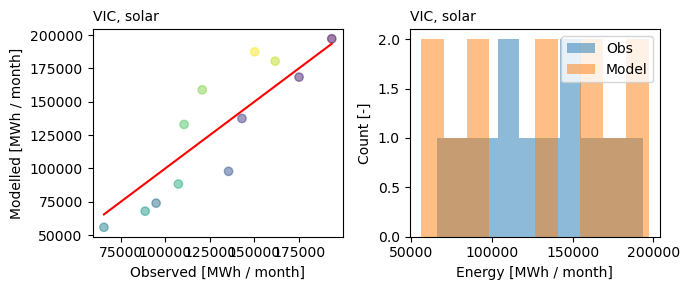

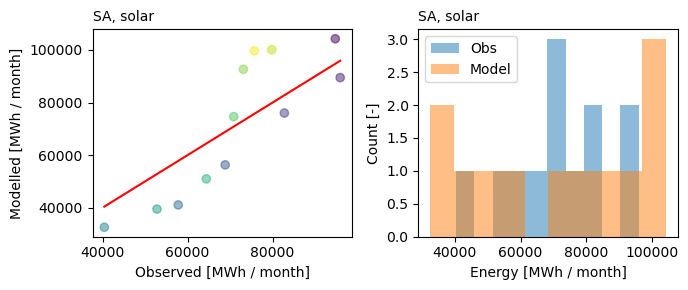

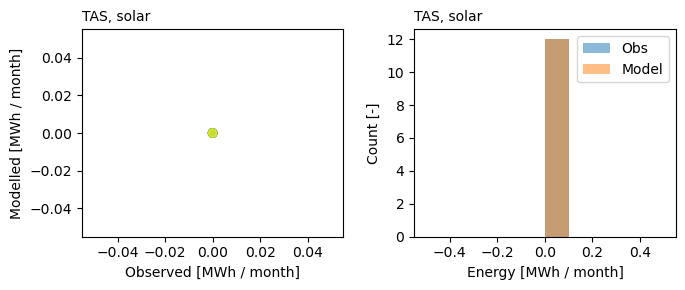

In [169]:
for region in wind_rez_current.region.values:
    plot_comparison(
        region,
        "solar",
        aemo_solar.sel(region=region)["power"].resample(time="1M").sum(),
        solar_rez_scaled.sel(region=region).resample(time="1M").sum(),
        "MWh / month"
    )

In [28]:
# wind_rez_scaled = wind_rez_current.assign_coords(scale_factor_2023=("region", wind_power.scale_factor_2023.values))

In [29]:
# solar_rez_scaled = solar_rez_current.assign_coords(scale_factor_2023=("region", solar_power.scale_factor_2023.values))